In [31]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [32]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [33]:
path = untar_data(URLs.MNIST_SAMPLE)

In [34]:
Path.BASE_PATH = path

In [35]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [36]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [37]:
(path/'valid').ls()

(#2) [Path('valid/7'),Path('valid/3')]

In [38]:
(path/'train/3').ls()

(#6131) [Path('train/3/49020.png'),Path('train/3/58048.png'),Path('train/3/45260.png'),Path('train/3/30483.png'),Path('train/3/47970.png'),Path('train/3/21228.png'),Path('train/3/49234.png'),Path('train/3/37827.png'),Path('train/3/25398.png'),Path('train/3/32685.png')...]

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1e31815750>, torch.Tensor)

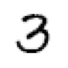

In [39]:
# take a 3 to test manually applying kernels as well as using functional pytorch to apply kernels
test_3 = tensor(Image.open(path/'train/3/49020.png'))
show_image(test_3), type(test_3)

## Apply a single kernel to an image and show the results
- Use raw python to apply a single kernel for creating convolutions
- Test 2 kernels on an image 

In [40]:
top_kernel_1 = tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]).float()
top_kernel_1

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

In [41]:
top_kernel_2 = tensor([[-1, -1, -1], [1, 1, 1], [0, 0, 0]]).float()
top_kernel_2

tensor([[-1., -1., -1.],
        [ 1.,  1.,  1.],
        [ 0.,  0.,  0.]])

In [42]:
def apply_kernel(image_tens, row, col, kernel):
  """
  Apply a kernel to a certain location of an image tensor
  """
  ks = kernel.shape[0]
  half_ks = ks//2
  # use row, col as the centre of the image to apply the kernel
  kernel_comp = (image_tens[row-half_ks:row+half_ks+1, col-half_ks:col+half_ks+1] * kernel).sum()
  return kernel_comp

In [43]:
# test the apply kernel function on the top left part of the image
apply_kernel(test_3, 1, 1, top_kernel_1)

tensor(0.)

In [44]:
test_3.shape

torch.Size([28, 28])

In [45]:
apply_kernel(test_3, 15, 15, top_kernel_1)

tensor(-287.)

In [46]:
apply_kernel(test_3, 3, 15, top_kernel_1)

tensor(438.)

In [47]:
apply_kernel(test_3, 4, 15, top_kernel_1)

tensor(756.)

In [48]:
apply_kernel(test_3, 5, 15, top_kernel_2)

tensor(318.)

In [61]:
def apply_convolution(image_tens, kernel):
  """
  Apply a kernel to the entire grid space
  """
  half_ks = kernel.shape[0]//2
  min_dim = half_ks
  max_dim = image_tens.shape[0] - half_ks

  conv = tensor([[apply_kernel(test_3, row, col, kernel) for col in range(min_dim, max_dim)] for row in range(min_dim, max_dim)])
  return conv
  

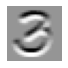

In [64]:
show_image(apply_convolution(test_3, top_kernel_1))

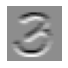

In [65]:
show_image(apply_convolution(test_3, top_kernel_2))

## Apply multiple kernels at a time
- Use pytorch functional to apply multiple convolutions with 4 different kernels

In [95]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

cross_kernel = tensor([[1, 1, 1], 
                       [0, 0, 1], 
                       [-3, 0, 1]])


In [96]:
all_kernels = torch.stack([top_kernel_1, diag1_edge, diag2_edge, cross_kernel], axis=0)
all_kernels.shape

torch.Size([4, 3, 3])

In [70]:
# load in a batch to test torch functional conv2d
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.train)
xb.shape

torch.Size([64, 1, 28, 28])

In [97]:
# reshape the weights. Only have a single input channel so (4, 1, 3, 3)
all_kernels.unsqueeze_(axis=1)
all_kernels.shape

torch.Size([4, 1, 3, 3])

In [98]:
all_kernels = all_kernels.cuda()

In [99]:
res = F.conv2d(xb, all_kernels)
res.shape

torch.Size([64, 4, 26, 26])

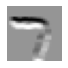

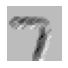

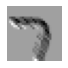

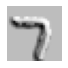

In [100]:
# look at the 4 output channels on the first image
for i in range(4):
  show_image(res[0, i])

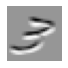

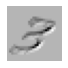

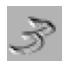

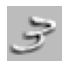

In [101]:
for i in range(4):
  show_image(res[2, i])

## Create a basic CNN using pytorch